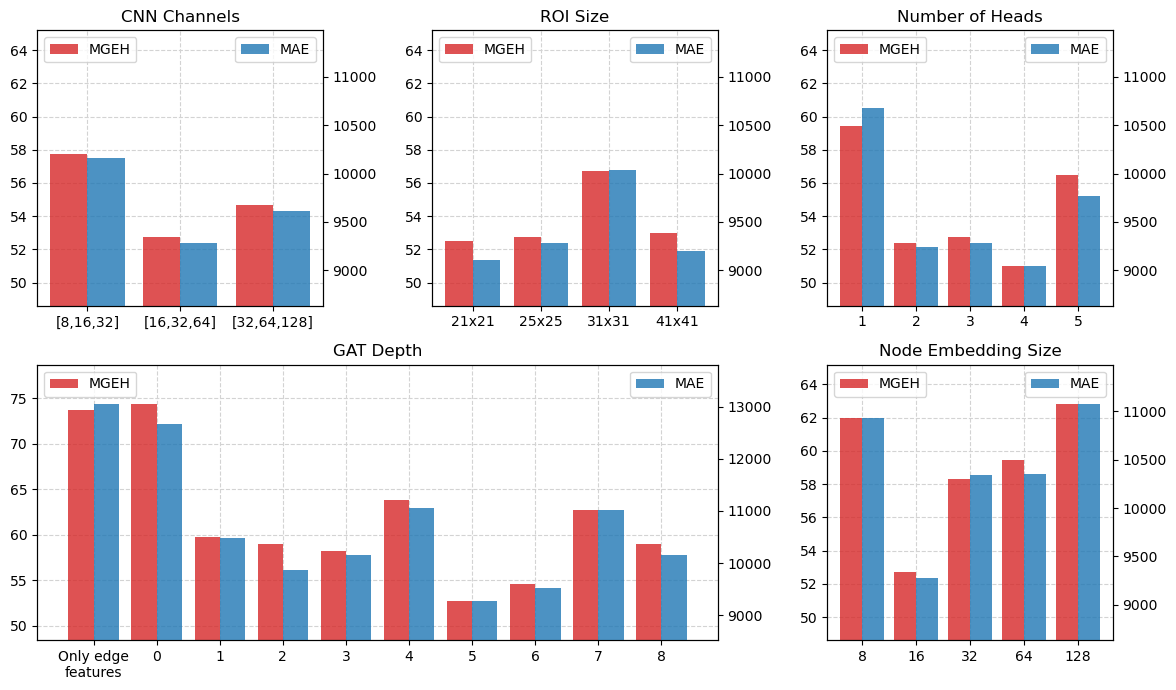

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV data
data = pd.read_csv("validation_results-hyperparam_tunning.csv")

# Subset the data based on the tuned hyperparameters
cnn_data = data[data['log_name'].str.contains('cnn')]
roi_data = data[data['log_name'].str.contains('roi')]
gat_depth_data = data[data['log_name'].str.contains('gat_depth')]
num_heads_data = data[data['log_name'].str.contains('num_heads')]
embedding_size_data = data[data['log_name'].str.contains('d\.log')]

# Determine universal ylim for GEH and MAE (excluding GAT Depth)
all_geh = pd.concat([cnn_data['min_valid_geh'], roi_data['min_valid_geh'], 
                     num_heads_data['min_valid_geh'], embedding_size_data['min_valid_geh']])
all_mae = pd.concat([cnn_data['min_valid_mae'], roi_data['min_valid_mae'], 
                     num_heads_data['min_valid_mae'], embedding_size_data['min_valid_mae']])
min_geh, max_geh = all_geh.min(), all_geh.max()
min_mae, max_mae = all_mae.min(), all_mae.max()
buffer_geh = (max_geh - min_geh) * 0.2
buffer_mae = (max_mae - min_mae) * 0.2
universal_geh_ylim = (min_geh - buffer_geh, max_geh + buffer_geh)
universal_mae_ylim = (min_mae - buffer_mae, max_mae + buffer_mae)

# Plot setup using gridspec for flexible layout
fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(2, 3)  # 2 rows, 3 columns

# Define axes with gridspec
axs = [
    fig.add_subplot(gs[0, 0]),  # CNN Channels
    fig.add_subplot(gs[0, 1]),  # ROI Size
    fig.add_subplot(gs[0, 2]),  # Number of Heads
    fig.add_subplot(gs[1, 0:2]),  # GAT Depth spanning 2 columns
    fig.add_subplot(gs[1, 2]),  # Node Embedding Size
]

# Function to plot for each subplot
def plot_subplot(ax, subset, title, x_labels, universal_ylim=True, rotate_xticks=False):
    x = np.arange(len(subset))  # Positions for bars
    width = 0.4  # Width of each bar

    # Set y-axis range
    if universal_ylim:
        ax.set_ylim(*universal_geh_ylim)
        ax2 = ax.twinx()
        ax2.set_ylim(*universal_mae_ylim)
    else:
        min_geh, max_geh = subset['min_valid_geh'].min(), subset['min_valid_geh'].max()
        min_mae, max_mae = subset['min_valid_mae'].min(), subset['min_valid_mae'].max()
        buffer_geh = (max_geh - min_geh) * 0.2
        buffer_mae = (max_mae - min_mae) * 0.2
        ax.set_ylim(min_geh - buffer_geh, max_geh + buffer_geh)
        ax2 = ax.twinx()
        ax2.set_ylim(min_mae - buffer_mae, max_mae + buffer_mae)

    # Ensure grid lines are below the bars
    ax.set_axisbelow(True)
    ax.grid(visible=True, which='major', color='lightgray', linestyle='--', linewidth=0.8)
    ax2.grid(visible=False)  # Only show grid lines on the primary axis

    # Define custom colors
    geh_color = (214/255, 39/255, 40/255)  # RGB for GEH
    mae_color = (31/255, 119/255, 180/255)  # RGB for MAE

    # Plot bars
    ax.bar(x - width/2, subset['min_valid_geh'], width, label="MGEH", alpha=0.8, color=geh_color)
    ax2.bar(x + width/2, subset['min_valid_mae'], width, label="MAE", alpha=0.8, color=mae_color)

    # Set labels and title
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45 if rotate_xticks else 0, ha='right' if rotate_xticks else 'center')
    ax.set_title(title)
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")

# Plot each hyperparameter category
plot_subplot(axs[0], cnn_data, "CNN Channels", ["[8,16,32]", "[16,32,64]", "[32,64,128]"])
plot_subplot(axs[1], roi_data, "ROI Size", ["21x21", "25x25", "31x31", "41x41"])
plot_subplot(axs[2], num_heads_data, "Number of Heads", [1, 2, 3, 4, 5])
plot_subplot(axs[3], gat_depth_data, "GAT Depth", ['Only edge\nfeatures', 0, 1, 2, 3, 4, 5, 6, 7, 8], universal_ylim=False)
plot_subplot(axs[4], embedding_size_data, "Node Embedding Size", [8, 16, 32, 64, 128])

plt.tight_layout()
plt.savefig('tunning.png')
plt.show()